In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import wandb
import torch.nn.functional as F

In [2]:
def load_dakshina_lexicon_pairs(filepath):
    pairs=[]
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue  # skip empty lines
            parts = line.split('\t')
            if len(parts) != 3:
                continue  # skip malformed lines
            devanagari_word, latin_word,_ = parts
            pairs.append((latin_word, devanagari_word))  # reverse order
    return pairs

In [3]:
def build_vocab(pairs, add_special_tokens=True):
    input_chars = set() # to ensure no repeated characters
    output_chars = set()

    # Collect unique characters from Latin (input) and Devanagari (output)
    for latin_word, devnagari_word in pairs:
        input_chars.update(list(latin_word))
        output_chars.update(list(devnagari_word))

    # Sort to keep it consistent
    input_chars = sorted(list(input_chars))
    output_chars = sorted(list(output_chars))

    # Add special tokens
    special_tokens = ['<pad>', '<sos>', '<eos>', '<unk>'] if add_special_tokens else []

    input_vocab = special_tokens + input_chars
    output_vocab = special_tokens + output_chars

    # Create dictionaries
    input_char2idx = {ch: idx for idx, ch in enumerate(input_vocab)}
    input_idx2char = {idx: ch for ch, idx in input_char2idx.items()}

    output_char2idx = {ch: idx for idx, ch in enumerate(output_vocab)}
    output_idx2char = {idx: ch for ch, idx in output_char2idx.items()}

    return input_char2idx, input_idx2char, output_char2idx, output_idx2char

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_vocab_size, embed_size, hidden_size, num_encoder_layers=1, cell_type='lstm', dropout=0.0):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_encoder_layers = num_encoder_layers
        self.cell_type = cell_type.lower()
        
        # Embedding layer
        self.embedding = nn.Embedding(input_vocab_size, embed_size)
        
        # RNN layer
        if self.cell_type == 'lstm':
            self.rnn = nn.LSTM(
                embed_size, hidden_size, num_encoder_layers,
                batch_first=True, dropout=dropout if num_encoder_layers > 1 else 0
            )
        elif self.cell_type == 'gru':
            self.rnn = nn.GRU(
                embed_size, hidden_size, num_encoder_layers,
                batch_first=True, dropout=dropout if num_encoder_layers > 1 else 0
            )
        else:  # default to RNN
            self.rnn = nn.RNN(
                embed_size, hidden_size, num_encoder_layers,
                batch_first=True, dropout=dropout if num_encoder_layers > 1 else 0
            )
    def forward(self, input_seq, lengths):
        """
        Forward pass for encoder
        
        Args:
            input_seq: Input sequence tensor [batch_size, max_seq_len]
            lengths: Actual lengths of input sequences (tensor)
            
        Returns:
            outputs: Unpacked encoder outputs [batch_size, max_seq_len, hidden_size]
            hidden: Hidden state for decoder initialization
        """
        batch_size = input_seq.size(0)
        
        # Important: ensure lengths is on CPU before using it
        if lengths.is_cuda:
            lengths = lengths.cpu()
        
        # Convert input to embeddings
        embedded = self.embedding(input_seq)  # [batch_size, seq_len, embed_size]
        
        # Pack padded sequence
        packed = nn.utils.rnn.pack_padded_sequence(
            embedded, lengths, batch_first=True, enforce_sorted=False
        )
        
        # Process with RNN
        if self.cell_type == 'lstm':
            packed_outputs, (hidden, cell) = self.rnn(packed)
            outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
            return outputs, (hidden, cell)
        else:
            packed_outputs, hidden = self.rnn(packed)
            outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
            return outputs, hidden

In [5]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.score = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, decoder_hidden, encoder_outputs):
        # decoder_hidden: [batch_size, hidden_size]
        # encoder_outputs: [batch_size, seq_len, hidden_size]
        seq_len = encoder_outputs.size(1)
        hidden = decoder_hidden.unsqueeze(1).repeat(1, seq_len, 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        scores = self.score(energy).squeeze(2)
        attn_weights = torch.softmax(scores, dim=1)
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)
        return context, attn_weights

In [6]:
class Decoder(nn.Module):
    def __init__(self, output_vocab_size, embed_size, hidden_size, num_decoder_layers=1, cell_type='lstm', dropout=0.0):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_decoder_layers = num_decoder_layers
        self.output_vocab_size = output_vocab_size
        self.cell_type = cell_type.lower()

        self.embedding = nn.Embedding(output_vocab_size, embed_size)
        self.attention = Attention(hidden_size)

        self.rnn = nn.LSTM(embed_size + hidden_size, hidden_size, num_decoder_layers,
                           batch_first=True, dropout=dropout if num_decoder_layers > 1 else 0) if self.cell_type == 'lstm' else \
                   nn.GRU(embed_size + hidden_size, hidden_size, num_decoder_layers,
                          batch_first=True, dropout=dropout if num_decoder_layers > 1 else 0)

        self.out = nn.Linear(hidden_size, output_vocab_size)

    def forward(self, input_seq, hidden, encoder_outputs):
        # input_seq: [batch_size, 1]
        embedded = self.embedding(input_seq).squeeze(1)  # [batch_size, embed_size]

        if self.cell_type == 'lstm':
            decoder_hidden = hidden[0][-1]  # last layer's hidden state
        else:
            decoder_hidden = hidden[-1]

        context, attn_weights = self.attention(decoder_hidden, encoder_outputs)  # [batch_size, hidden_size]

        rnn_input = torch.cat((embedded, context), dim=1).unsqueeze(1)  # [batch_size, 1, embed+context]

        if self.cell_type == 'lstm':
            output, (hidden, cell) = self.rnn(rnn_input, hidden)
            output = self.out(output)  # [batch_size, 1, vocab_size]
            return output, (hidden, cell), attn_weights
        else:
            output, hidden = self.rnn(rnn_input, hidden)
            output = self.out(output)  # [batch_size, 1, vocab_size]
            return output, hidden, attn_weights

In [7]:
class TransliterationDataset(Dataset):
    def __init__(self, pairs, input_char2idx, output_char2idx):
        
        '''
        pairs: list of (latin_word, devnagari_word) tuples.
        input_char2idx: dictionary mapping each Latin character to an index.
        output_char2idx: dictionary mapping each Devanagari character to an index.
        '''
            
        self.pairs = pairs
        self.input_char2idx = input_char2idx
        self.output_char2idx = output_char2idx

    # This converts a word into a list of token indices, e.g., India -> [8,13,3,8,0]
    def encode_word(self, word, char2idx, add_sos_eos=False):
        tokens = [char2idx.get(c, char2idx['<unk>']) for c in word]
        if add_sos_eos:
            tokens = [char2idx['<sos>']] + tokens + [char2idx['<eos>']]
        return tokens

    #  Give the total number of latin, devnagri pairs in the dataset
    def __len__(self): 
        return len(self.pairs)

    # This takes the index of the word in latin and gets the latin, devnagri pair. 
        # Then, it converts each word to list of indices and gives the pair of list of indices
    def __getitem__(self, idx):
        latin, devnagari = self.pairs[idx]
        input_ids = self.encode_word(latin, self.input_char2idx)
        target_ids = self.encode_word(devnagari, self.output_char2idx, add_sos_eos=True)
        return input_ids, target_ids

In [8]:
#  Adds pad tokens, given the sequnece, maximum length and pad-token
def pad_seq(seq, max_len, pad_token):
    return seq + [pad_token] * (max_len - len(seq))

def collate_fn(batch):
    '''
    batch: List of tuples [(input1, target1), (input2, target2), ...]

    '''
    input_seqs, target_seqs = zip(*batch)

    input_max_len = max(len(seq) for seq in input_seqs)
    target_max_len = max(len(seq) for seq in target_seqs)

    # Adds padding for seqeuces so that sequence length = maximum sequence length in the batch. 
    # Now all sequenes in the batch are of same length 
    input_padded = [pad_seq(seq, input_max_len, pad_token=input_char2idx['<pad>']) for seq in input_seqs]
    target_padded = [pad_seq(seq, target_max_len, pad_token=output_char2idx['<pad>']) for seq in target_seqs]

    input_tensor = torch.tensor(input_padded, dtype=torch.long)
    target_tensor = torch.tensor(target_padded, dtype=torch.long)

    input_lengths = torch.tensor([len(seq) for seq in input_seqs])
    target_lengths = torch.tensor([len(seq) for seq in target_seqs])

    return input_tensor, input_lengths, target_tensor, target_lengths

In [9]:
# sweep_config = {
#     'method': 'bayes',  # Could also be 'random' or 'grid'
#     'metric': {
#         'name': 'token_accuracy',
#         'goal': 'maximize'
#     },
#     'parameters': {
#         'embed_size': {'values': [16, 32, 64]},
#         'hidden_size': {'values': [16, 32, 64]},
#         'cell_type': {'values': ['RNN', 'GRU', 'LSTM']},
#         'dropout': {'values': [0.3, 0.4, 0.5]},
#         'batch_size': {'values': [128, 256, 512]},
#         'learning_rate': {'values': [5e-3, 1e-3, 5e-4]},
#         'beam_size': {'values': [3, 4, 5]}
#     },
#     'early_terminate': {
#         'type': 'hyperband',
#         'min_iter': 7
#     }
# }

In [10]:
# import wandb
# wandb.login(key="70a00ae1607c730fb9cd50b1268b191bec7a2901")

In [11]:
# filepath = "/kaggle/input/dakshina-dataset-v1-0/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv"
# pairs = load_dakshina_lexicon_pairs(filepath)

# input_char2idx, input_idx2char, output_char2idx, output_idx2char = build_vocab(pairs)

# print("Latin char2idx:", list(input_char2idx.items())[:5])
# print("Devanagari idx2char:", list(output_idx2char.items())[:5])

# print(len(list(output_char2idx.keys())))

# dataset = TransliterationDataset(pairs, input_char2idx, output_char2idx)

# filepath_val = "/kaggle/input/dakshina-dataset-v1-0/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv"
# pairs_val = load_dakshina_lexicon_pairs(filepath_val)
# dataset_val = TransliterationDataset(pairs_val, input_char2idx, output_char2idx)

In [12]:
# def train():
#     wandb.init()
#     config = wandb.config
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     # Initialize encoder and decoder
#     encoder = Encoder(
#         input_vocab_size=len(input_char2idx),
#         embed_size=config.embed_size,
#         hidden_size=config.hidden_size,
#         num_encoder_layers=1,
#         cell_type=config.cell_type,
#         dropout=config.dropout
#     ).to(device)

#     decoder = Decoder(
#         output_vocab_size=len(output_char2idx),
#         embed_size=config.embed_size,
#         hidden_size=config.hidden_size,
#         num_decoder_layers=1,
#         cell_type=config.cell_type,
#         dropout=config.dropout
#     ).to(device)

#     encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=config.learning_rate, weight_decay=1e-5)
#     decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=config.learning_rate, weight_decay=1e-5)
#     criterion = nn.CrossEntropyLoss(ignore_index=output_char2idx['<pad>'])

#     dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True, collate_fn=collate_fn)
#     dataloader_val = DataLoader(dataset_val, batch_size=1, shuffle=False, collate_fn=collate_fn)

#     num_epochs = 20
#     for epoch in range(num_epochs):
#         # ======== TRAINING ========
#         encoder.train()
#         decoder.train()
#         total_loss = 0

#         with tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
#             for input_tensor, input_lengths, target_tensor, target_lengths in pbar:
#                 input_tensor = input_tensor.to(device)
#                 target_tensor = target_tensor.to(device)

#                 encoder_optimizer.zero_grad()
#                 decoder_optimizer.zero_grad()

#                 encoder_outputs, encoder_hidden = encoder(input_tensor, input_lengths)
#                 decoder_input = target_tensor[:, 0].unsqueeze(1)  # <sos>
#                 decoder_hidden = encoder_hidden

#                 loss = 0
#                 max_target_len = target_tensor.size(1)

#                 for t in range(1, max_target_len):
#                     decoder_output, decoder_hidden,att_wts= decoder(decoder_input, decoder_hidden,encoder_outputs)
#                     output = decoder_output.squeeze(1)
#                     # print(f'output = {output}')
#                     # print(f'target tensor = {target_tensor[:,t]}')
#                     loss += criterion(output, target_tensor[:, t])
#                     decoder_input = target_tensor[:, t].unsqueeze(1)  # Teacher forcing

#                 loss.backward()
#                 torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1.0)
#                 torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=1.0)

#                 encoder_optimizer.step()
#                 decoder_optimizer.step()

#                 total_loss += loss.item() / (max_target_len - 1)

#         avg_loss = total_loss / len(dataloader)
#         print(f"Epoch {epoch+1}/{num_epochs} Train Loss: {avg_loss:.4f}")

#         # ======== VALIDATION ========
#         encoder.eval()
#         decoder.eval()
#         correct_sequences = 0
#         total_sequences = 0
#         correct_tokens = 0
#         total_tokens = 0
#         beam_width = config.beam_size  # You can change this
        
#         with torch.no_grad():
#             for input_tensor, input_lengths, target_tensor, target_lengths in dataloader_val:
#                 input_tensor = input_tensor.to(device)
#                 target_tensor = target_tensor.to(device)
        
#                 encoder_outputs, encoder_hidden = encoder(input_tensor, input_lengths)
#                 max_target_len = target_tensor.size(1)
#                 total_sequences += 1
        
#                 # Beam is a list of tuples: (sequence_so_far, cumulative_log_prob, decoder_hidden)
#                 beam = [([output_char2idx['<sos>']], 0.0, encoder_hidden)]
        
#                 completed_sequences = []
        
#                 for _ in range(1, max_target_len):
#                     new_beam = []
#                     for seq, score, hidden in beam:
#                         decoder_input = torch.tensor([[seq[-1]]], device=device)
#                         decoder_output, hidden_next,_ = decoder(decoder_input, hidden,encoder_outputs)
#                         log_probs = F.log_softmax(decoder_output.squeeze(1), dim=1)
        
#                         topk_log_probs, topk_indices = log_probs.topk(beam_width)
        
#                         for k in range(beam_width):
#                             next_token = topk_indices[0][k].item()
#                             next_score = score + topk_log_probs[0][k].item()
#                             new_seq = seq + [next_token]
#                             new_beam.append((new_seq, next_score, hidden_next))
        
#                     # Keep top `beam_width` beams with highest scores
#                     beam = sorted(new_beam, key=lambda x: x[1], reverse=True)[:beam_width]
        
#                     # Move completed sequences out
#                     beam, completed = [], []
#                     for seq, score, hidden in new_beam:
#                         if seq[-1] == output_char2idx['<eos>']:
#                             completed_sequences.append((seq, score))
#                         else:
#                             beam.append((seq, score, hidden))
#                     beam = sorted(beam, key=lambda x: x[1], reverse=True)[:beam_width]
        
#                 # Choose best completed or best incomplete beam
#                 if completed_sequences:
#                     best_seq = max(completed_sequences, key=lambda x: x[1])[0]
#                 else:
#                     best_seq = max(beam, key=lambda x: x[1])[0]
        
#                 # Remove <sos> if present
#                 if best_seq[0] == output_char2idx['<sos>']:
#                     best_seq = best_seq[1:]
        
#                 # Compare prediction with target
#                 target_seq = target_tensor[0, 1:].tolist()
#                 pad_idx = output_char2idx['<pad>']
        
#                 # Token accuracy
#                 for pred_token, tgt_token in zip(best_seq, target_seq):
#                     if tgt_token == pad_idx:
#                         break
#                     if pred_token == tgt_token:
#                         correct_tokens += 1
#                     total_tokens += 1
        
#                 # Sequence accuracy
#                 target_trimmed = [t for t in target_seq if t != pad_idx]
#                 best_seq_trimmed = best_seq[:len(target_trimmed)]
#                 if best_seq_trimmed == target_trimmed:
#                     correct_sequences += 1
        
#                 # Optional print
#                 # predicted_word = indices_to_words([best_seq], output_idx2char)[0]
#                 # actual_word = indices_to_words([target_trimmed], output_idx2char)[0]
#                 # # print(f"Predicted: {predicted_word.ljust(20)} | Actual: {actual_word}")
        
#         sequence_accuracy = correct_sequences / total_sequences if total_sequences > 0 else 0
#         token_accuracy = correct_tokens / total_tokens if total_tokens > 0 else 0
        
#         print(f"Token Accuracy: {token_accuracy:.4f}")
#         print(f"Sequence Accuracy: {sequence_accuracy:.4f}")
        
#         wandb.log({
#             "epoch": epoch + 1,
#             "train_loss": avg_loss,
#             "token_accuracy": token_accuracy,
#             "sequence_accuracy": sequence_accuracy
#         })

In [13]:
# sweep_id = wandb.sweep(sweep_config, project="DA6401 Assign3 - Attention")
# wandb.agent(sweep_id, function=train, count=20)
# wandb.finish()

In [14]:
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

filepath = "/kaggle/input/dakshina-dataset-v1-0/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv"
pairs = load_dakshina_lexicon_pairs(filepath)

input_char2idx, input_idx2char, output_char2idx, output_idx2char = build_vocab(pairs)

print("Latin char2idx:", list(input_char2idx.items())[:5])
print("Devanagari idx2char:", list(output_idx2char.items())[:5])

print(len(list(output_char2idx.keys())))

dataset = TransliterationDataset(pairs, input_char2idx, output_char2idx)

filepath_test = "/kaggle/input/dakshina-dataset-v1-0/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv"
pairs_test = load_dakshina_lexicon_pairs(filepath_test)
dataset_test = TransliterationDataset(pairs_test, input_char2idx, output_char2idx)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

filepath_val = "/kaggle/input/dakshina-dataset-v1-0/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv"
pairs_val = load_dakshina_lexicon_pairs(filepath_val)
dataset_val = TransliterationDataset(pairs_val, input_char2idx, output_char2idx)
dataloader_val = DataLoader(dataset_val, batch_size=1, shuffle=False, collate_fn=collate_fn)

dataset = TransliterationDataset(pairs, input_char2idx, output_char2idx)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

#  Best configuration
embed_size=64
num_encoder_layers=1
num_decoder_layers=1
hidden_size=64
cell_type='lstm'
dropout=0.4
batch_size=128
learning_rate=0.005
beam_size=4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize encoder and decoder
encoder = Encoder(
    input_vocab_size=len(input_char2idx),
    embed_size=embed_size,
    hidden_size=hidden_size,
    num_encoder_layers=num_encoder_layers,
    cell_type=cell_type,
    dropout=dropout
).to(device)

decoder = Decoder(
    output_vocab_size=len(output_char2idx),
    embed_size=embed_size,
    hidden_size=hidden_size,
    num_decoder_layers=num_decoder_layers,
    cell_type=cell_type,
    dropout=dropout
).to(device)

encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate, weight_decay=1e-5)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss(ignore_index=output_char2idx['<pad>'])

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

num_epochs = 20
for epoch in range(num_epochs):
    # ======== TRAINING ========
    encoder.train()
    decoder.train()
    total_loss = 0

    with tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
        for input_tensor, input_lengths, target_tensor, target_lengths in pbar:
            input_tensor = input_tensor.to(device)
            target_tensor = target_tensor.to(device)

            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()

            encoder_outputs, encoder_hidden = encoder(input_tensor, input_lengths)
            decoder_input = target_tensor[:, 0].unsqueeze(1)  # <sos>
            decoder_hidden = encoder_hidden

            loss = 0
            max_target_len = target_tensor.size(1)

            for t in range(1, max_target_len):
                decoder_output, decoder_hidden,_= decoder(decoder_input, decoder_hidden,encoder_outputs)
                output = decoder_output.squeeze(1)
                # print(f'output = {output}')
                # print(f'target tensor = {target_tensor[:,t]}')
                loss += criterion(output, target_tensor[:, t])
                decoder_input = target_tensor[:, t].unsqueeze(1)  # Teacher forcing

            loss.backward()
            torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1.0)
            torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=1.0)

            encoder_optimizer.step()
            decoder_optimizer.step()

            total_loss += loss.item() / (max_target_len - 1)

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs} Train Loss: {avg_loss:.4f}")

    # # ======== VALIDATION ========
    # encoder.eval()
    # decoder.eval()
    # correct_sequences = 0
    # total_sequences = 0
    # correct_tokens = 0
    # total_tokens = 0
    # beam_width = beam_size  # You can change this
    # with torch.no_grad():
    #     for input_tensor, input_lengths, target_tensor, target_lengths in dataloader_val:
    #         input_tensor = input_tensor.to(device)
    #         target_tensor = target_tensor.to(device)
    
    #         encoder_outputs, encoder_hidden = encoder(input_tensor, input_lengths)
    #         max_target_len = target_tensor.size(1)
    #         total_sequences += 1
    
    #         # Beam is a list of tuples: (sequence_so_far, cumulative_log_prob, decoder_hidden)
    #         beam = [([output_char2idx['<sos>']], 0.0, encoder_hidden)]
    
    #         completed_sequences = []
    
    #         for _ in range(1, max_target_len):
    #             new_beam = []
    #             for seq, score, hidden in beam:
    #                 decoder_input = torch.tensor([[seq[-1]]], device=device)
    #                 decoder_output, hidden_next,_ = decoder(decoder_input, hidden,encoder_outputs)
    #                 log_probs = F.log_softmax(decoder_output.squeeze(1), dim=1)
    
    #                 topk_log_probs, topk_indices = log_probs.topk(beam_width)
    
    #                 for k in range(beam_width):
    #                     next_token = topk_indices[0][k].item()
    #                     next_score = score + topk_log_probs[0][k].item()
    #                     new_seq = seq + [next_token]
    #                     new_beam.append((new_seq, next_score, hidden_next))
    
    #             # Keep top `beam_width` beams with highest scores
    #             beam = sorted(new_beam, key=lambda x: x[1], reverse=True)[:beam_width]
    
    #             # Move completed sequences out
    #             beam, completed = [], []
    #             for seq, score, hidden in new_beam:
    #                 if seq[-1] == output_char2idx['<eos>']:
    #                     completed_sequences.append((seq, score))
    #                 else:
    #                     beam.append((seq, score, hidden))
    #             beam = sorted(beam, key=lambda x: x[1], reverse=True)[:beam_width]
    
    #         # Choose best completed or best incomplete beam
    #         if completed_sequences:
    #             best_seq = max(completed_sequences, key=lambda x: x[1])[0]
    #         else:
    #             best_seq = max(beam, key=lambda x: x[1])[0]
    
    #         # Remove <sos> if present
    #         if best_seq[0] == output_char2idx['<sos>']:
    #             best_seq = best_seq[1:]
    
    #         # Compare prediction with target
    #         target_seq = target_tensor[0, 1:].tolist()
    #         pad_idx = output_char2idx['<pad>']
    
    #         # Token accuracy
    #         for pred_token, tgt_token in zip(best_seq, target_seq):
    #             if tgt_token == pad_idx:
    #                 break
    #             if pred_token == tgt_token:
    #                 correct_tokens += 1
    #             total_tokens += 1
    
    #         # Sequence accuracy
    #         target_trimmed = [t for t in target_seq if t != pad_idx]
    #         best_seq_trimmed = best_seq[:len(target_trimmed)]
    #         if best_seq_trimmed == target_trimmed:
    #             correct_sequences += 1
    
    #         # Optional print
    #         # predicted_word = indices_to_words([best_seq], output_idx2char)[0]
    #         # actual_word = indices_to_words([target_trimmed], output_idx2char)[0]
    #         # # print(f"Predicted: {predicted_word.ljust(20)} | Actual: {actual_word}")
    
    # sequence_accuracy = correct_sequences / total_sequences if total_sequences > 0 else 0
    # token_accuracy = correct_tokens / total_tokens if total_tokens > 0 else 0
    
    # print(f"Token Accuracy: {token_accuracy:.4f}")
    # print(f"Sequence Accuracy: {sequence_accuracy:.4f}")

Latin char2idx: [('<pad>', 0), ('<sos>', 1), ('<eos>', 2), ('<unk>', 3), ('a', 4)]
Devanagari idx2char: [(0, '<pad>'), (1, '<sos>'), (2, '<eos>'), (3, '<unk>'), (4, 'ँ')]
67


Epoch 1/20: 100%|██████████| 346/346 [00:15<00:00, 22.31it/s]


Epoch 1/20 Train Loss: 1.7709


Epoch 2/20: 100%|██████████| 346/346 [00:14<00:00, 23.94it/s]


Epoch 2/20 Train Loss: 0.9018


Epoch 3/20: 100%|██████████| 346/346 [00:14<00:00, 23.12it/s]


Epoch 3/20 Train Loss: 0.6078


Epoch 4/20: 100%|██████████| 346/346 [00:14<00:00, 23.80it/s]


Epoch 4/20 Train Loss: 0.4753


Epoch 5/20: 100%|██████████| 346/346 [00:14<00:00, 23.74it/s]


Epoch 5/20 Train Loss: 0.4111


Epoch 6/20: 100%|██████████| 346/346 [00:14<00:00, 23.99it/s]


Epoch 6/20 Train Loss: 0.3682


Epoch 7/20: 100%|██████████| 346/346 [00:14<00:00, 23.90it/s]


Epoch 7/20 Train Loss: 0.3403


Epoch 8/20: 100%|██████████| 346/346 [00:14<00:00, 23.67it/s]


Epoch 8/20 Train Loss: 0.3135


Epoch 9/20: 100%|██████████| 346/346 [00:14<00:00, 24.03it/s]


Epoch 9/20 Train Loss: 0.3008


Epoch 10/20: 100%|██████████| 346/346 [00:14<00:00, 23.59it/s]


Epoch 10/20 Train Loss: 0.2830


Epoch 11/20: 100%|██████████| 346/346 [00:14<00:00, 23.86it/s]


Epoch 11/20 Train Loss: 0.2756


Epoch 12/20: 100%|██████████| 346/346 [00:14<00:00, 23.57it/s]


Epoch 12/20 Train Loss: 0.2613


Epoch 13/20: 100%|██████████| 346/346 [00:14<00:00, 23.82it/s]


Epoch 13/20 Train Loss: 0.2559


Epoch 14/20: 100%|██████████| 346/346 [00:14<00:00, 23.55it/s]


Epoch 14/20 Train Loss: 0.2439


Epoch 15/20: 100%|██████████| 346/346 [00:14<00:00, 23.76it/s]


Epoch 15/20 Train Loss: 0.2405


Epoch 16/20: 100%|██████████| 346/346 [00:14<00:00, 23.58it/s]


Epoch 16/20 Train Loss: 0.2284


Epoch 17/20: 100%|██████████| 346/346 [00:14<00:00, 23.72it/s]


Epoch 17/20 Train Loss: 0.2229


Epoch 18/20: 100%|██████████| 346/346 [00:14<00:00, 23.57it/s]


Epoch 18/20 Train Loss: 0.2163


Epoch 19/20: 100%|██████████| 346/346 [00:14<00:00, 23.51it/s]


Epoch 19/20 Train Loss: 0.2126


Epoch 20/20: 100%|██████████| 346/346 [00:14<00:00, 23.44it/s]

Epoch 20/20 Train Loss: 0.2078


In [15]:
# ======== TEST ========
encoder.eval()
decoder.eval()
correct_sequences = 0
total_sequences = 0
correct_tokens = 0
total_tokens = 0
beam_width = beam_size  # You can change this
result=[]
correct_w_count=10
visual_words=[]
visual_att = []
input_words = []
with torch.no_grad():
    for input_tensor, input_lengths, target_tensor, target_lengths in dataloader_test:
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        encoder_outputs, encoder_hidden = encoder(input_tensor, input_lengths)
        max_target_len = target_tensor.size(1)
        total_sequences += 1

        # Beam is a list of tuples: (sequence_so_far, cumulative_log_prob, decoder_hidden)
        # beam = [([output_char2idx['<sos>']], 0.0, encoder_hidden)]

        # completed_sequences = []
        # att=[]
        # for _ in range(1, max_target_len):
        #     new_beam = []
        #     for seq, score, hidden in beam:
        #         decoder_input = torch.tensor([[seq[-1]]], device=device)
        #         decoder_output, hidden_next,_ = decoder(decoder_input, hidden,encoder_outputs)
                
        #         log_probs = F.log_softmax(decoder_output.squeeze(1), dim=1)

        #         topk_log_probs, topk_indices = log_probs.topk(beam_width)
        #         for k in range(beam_width):
        #             next_token = topk_indices[0][k].item()
        #             next_score = score + topk_log_probs[0][k].item()
        #             new_seq = seq + [next_token]
        #             new_beam.append((new_seq, next_score, hidden_next))
                
        #     # Keep top `beam_width` beams with highest scores
        #     beam = sorted(new_beam, key=lambda x: x[1], reverse=True)[:beam_width]

        #     # Move completed sequences out
        #     beam, completed = [], []
        #     for seq, score, hidden in new_beam:
        #         if seq[-1] == output_char2idx['<eos>']:
        #             completed_sequences.append((seq, score))
        #         else:
        #             beam.append((seq, score, hidden))
        #     beam = sorted(beam, key=lambda x: x[1], reverse=True)[:beam_width]

        # # Choose best completed or best incomplete beam
        # if completed_sequences:
        #     best_seq = max(completed_sequences, key=lambda x: x[1])[0]
        # else:
        #     best_seq = max(beam, key=lambda x: x[1])[0]

        completed_sequences = []    # will hold tuples (seq, score, attn_list)
        # Initialize beam: sequence=[<sos>], score=0.0, hidden=init, attn_list=[]
        beam = [([output_char2idx['<sos>']], 0.0, encoder_hidden, [])]
        
        for _ in range(1, max_target_len):
            new_beam = []
            for seq, score, hidden, attn_list in beam:
                decoder_input = torch.tensor([[seq[-1]]], device=device)
                decoder_output, hidden_next, attn_weights = decoder(
                    decoder_input, hidden, encoder_outputs
                )
                # attn_weights shape: (batch=1, src_len) or (1, 1, src_len) depending on your implementation
        
                log_probs = F.log_softmax(decoder_output.squeeze(1), dim=1)
                topk_log_probs, topk_indices = log_probs.topk(beam_width)
        
                for k in range(beam_width):
                    next_token = topk_indices[0][k].item()
                    next_score = score + topk_log_probs[0][k].item()
                    new_seq = seq + [next_token]
                    # Copy and append the new attention weights
                    new_attn_list = attn_list + [attn_weights.detach().cpu()]
                    new_beam.append((new_seq, next_score, hidden_next, new_attn_list))
        
            # prune to keep only top beams
            new_beam = sorted(new_beam, key=lambda x: x[1], reverse=True)[:beam_width]
        
            # separate completed and ongoing beams
            beam, completed = [], []
            for seq, score, hidden, attn_list in new_beam:
                if seq[-1] == output_char2idx['<eos>']:
                    completed_sequences.append((seq, score, attn_list))
                else:
                    beam.append((seq, score, hidden, attn_list))
            beam = sorted(beam, key=lambda x: x[1], reverse=True)[:beam_width]
        
        # pick the best sequence
        if completed_sequences:
            best_seq, best_score, best_attn = max(completed_sequences, key=lambda x: x[1])
        else:
            best_seq, best_score, _best_hidden, best_attn = max(beam, key=lambda x: x[1])
                
        # Remove <sos> if present
        if best_seq[0] == output_char2idx['<sos>']:
            best_seq = best_seq[1:]
        
        # Compare prediction with target
        target_seq = target_tensor[0, 1:].tolist()
        pad_idx = output_char2idx['<pad>']
        
        # Token accuracy
        for pred_token, tgt_token in zip(best_seq, target_seq):
            if tgt_token == pad_idx:
                break
            if pred_token == tgt_token:
                correct_tokens += 1
            total_tokens += 1

        # Sequence accuracy
        target_trimmed = [t for t in target_seq if t != pad_idx]
        best_seq_trimmed = best_seq[:len(target_trimmed)]
        if best_seq_trimmed == target_trimmed:
            correct_sequences += 1
            if(correct_w_count>0):
                correct_w_count-=1
                visual_words.append(best_seq_trimmed)
                visual_att.append(best_attn)
                input_words.append(input_tensor)
                
        if best_seq[-1] == output_char2idx['<eos>']:
            best_seq = best_seq[:best_seq.index(output_char2idx['<eos>'])]
        predicted_word=''.join(output_idx2char[i] for i in best_seq)
        target_seq = target_tensor.tolist() if hasattr(target_tensor, 'tolist') else target_tensor
        if isinstance(target_seq[0], list):
            target_seq = target_seq[0]
        # Remove <sos> and truncate at <eos> if present
        if target_seq[0] == output_char2idx['<sos>']:
            target_seq = target_seq[1:]
        if output_char2idx.get('<eos>') in target_seq:
            target_seq = target_seq[:target_seq.index(output_char2idx['<eos>'])]
        
        target_word = ''.join(output_idx2char[i] for i in target_seq)
        
        input_seq = input_tensor.tolist() if hasattr(input_tensor, 'tolist') else input_tensor
        if isinstance(input_seq[0], list):
            input_seq = input_seq[0]

        if input_seq[0] == input_char2idx['<sos>']:
            input_seq = input_seq[1:]
        if input_char2idx.get('<eos>') in input_seq:
            input_seq = input_seq[:input_seq.index(input_char2idx['<eos>'])]
        input_word = ''.join(input_idx2char[i] for i in input_seq)

        result.append((input_word, predicted_word, target_word))
        # Optional print
        # predicted_word = indices_to_words([best_seq], output_idx2char)[0]
        # actual_word = indices_to_words([target_trimmed], output_idx2char)[0]
        # # print(f"Predicted: {predicted_word.ljust(20)} | Actual: {actual_word}")

sequence_accuracy = correct_sequences / total_sequences if total_sequences > 0 else 0
token_accuracy = correct_tokens / total_tokens if total_tokens > 0 else 0
print("Test:")
print(f"Token Accuracy: {token_accuracy:.4f}")
print(f"Sequence Accuracy: {sequence_accuracy:.4f}")
print(f"Best Sequences: {visual_words}\n\n")
print(f"Best Attentions: {visual_att}")

Test:
Token Accuracy: 0.7550
Sequence Accuracy: 0.4145
Best Sequences: [[7, 5, 19, 2], [7, 5, 19, 54, 34, 2], [7, 5, 19, 63, 5, 2], [7, 5, 19, 63, 45, 2], [7, 5, 21, 53, 45, 19, 2], [7, 5, 21, 53, 45, 19, 2], [7, 5, 37, 53, 2], [7, 5, 37, 60, 45, 55, 2], [7, 5, 41, 53, 38, 55, 2], [7, 5, 41, 53, 38, 55, 2]]


Best Attentions: [[tensor([[0.4258, 0.1052, 0.4690]]), tensor([[3.0240e-05, 4.9484e-01, 5.0513e-01]]), tensor([[9.5483e-05, 1.8742e-02, 9.8116e-01]]), tensor([[1.5061e-05, 3.6360e-04, 9.9962e-01]])], [tensor([[0.6655, 0.2162, 0.1134, 0.0026, 0.0023]]), tensor([[1.2787e-05, 4.1974e-01, 5.7477e-01, 3.0479e-03, 2.4297e-03]]), tensor([[5.5625e-05, 2.4975e-02, 8.7185e-01, 8.2145e-02, 2.0979e-02]]), tensor([[1.3318e-06, 3.3257e-05, 4.9103e-03, 9.0233e-01, 9.2727e-02]]), tensor([[2.3329e-13, 1.6253e-12, 2.4468e-08, 7.8047e-04, 9.9922e-01]]), tensor([[2.1579e-14, 9.4779e-13, 4.4503e-09, 3.2958e-05, 9.9997e-01]])], [tensor([[0.6890, 0.1739, 0.1301, 0.0048, 0.0023]]), tensor([[6.8232e-06, 3

In [16]:
for each in visual_att:
    for letter in each:
        print(letter)
    print("\n")

tensor([[0.4258, 0.1052, 0.4690]])
tensor([[3.0240e-05, 4.9484e-01, 5.0513e-01]])
tensor([[9.5483e-05, 1.8742e-02, 9.8116e-01]])
tensor([[1.5061e-05, 3.6360e-04, 9.9962e-01]])


tensor([[0.6655, 0.2162, 0.1134, 0.0026, 0.0023]])
tensor([[1.2787e-05, 4.1974e-01, 5.7477e-01, 3.0479e-03, 2.4297e-03]])
tensor([[5.5625e-05, 2.4975e-02, 8.7185e-01, 8.2145e-02, 2.0979e-02]])
tensor([[1.3318e-06, 3.3257e-05, 4.9103e-03, 9.0233e-01, 9.2727e-02]])
tensor([[2.3329e-13, 1.6253e-12, 2.4468e-08, 7.8047e-04, 9.9922e-01]])
tensor([[2.1579e-14, 9.4779e-13, 4.4503e-09, 3.2958e-05, 9.9997e-01]])


tensor([[0.6890, 0.1739, 0.1301, 0.0048, 0.0023]])
tensor([[6.8232e-06, 3.9444e-01, 5.9036e-01, 8.6100e-03, 6.5877e-03]])
tensor([[4.1381e-05, 2.3255e-02, 8.0657e-01, 1.3711e-01, 3.3024e-02]])
tensor([[3.9604e-07, 2.1023e-05, 7.0039e-03, 7.9288e-01, 2.0009e-01]])
tensor([[2.8192e-14, 6.7105e-14, 6.7126e-08, 1.6092e-04, 9.9984e-01]])
tensor([[1.5596e-14, 3.1155e-12, 6.7070e-08, 1.8894e-05, 9.9998e-01]])


tensor

In [17]:
def get_words_from_tensor(tens,dict_char2idx,dict_idx2char):
    target_seq = tens.tolist() if hasattr(tens, 'tolist') else tens
    if isinstance(target_seq[0], list):
        target_seq = target_seq[0]
    if target_seq[0] == dict_char2idx['<sos>']:
        target_seq = target_seq[1:]
    if dict_char2idx.get('<eos>') in target_seq:
        target_seq = target_seq[:target_seq.index(dict_char2idx['<eos>'])]
    chars_seq = [dict_idx2char[i] for i in target_seq]
    return ''.join(chars_seq)

Latin word = ank, Devnagri word = अंक


/tmp/ipykernel_35/1991647216.py:30: UserWarning: Glyph 2309 (\N{DEVANAGARI LETTER A}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/1991647216.py:30: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
/tmp/ipykernel_35/1991647216.py:30: UserWarning: Glyph 2306 (\N{DEVANAGARI SIGN ANUSVARA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/1991647216.py:30: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2309 (\N{DEVANAGARI LETTER A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: G

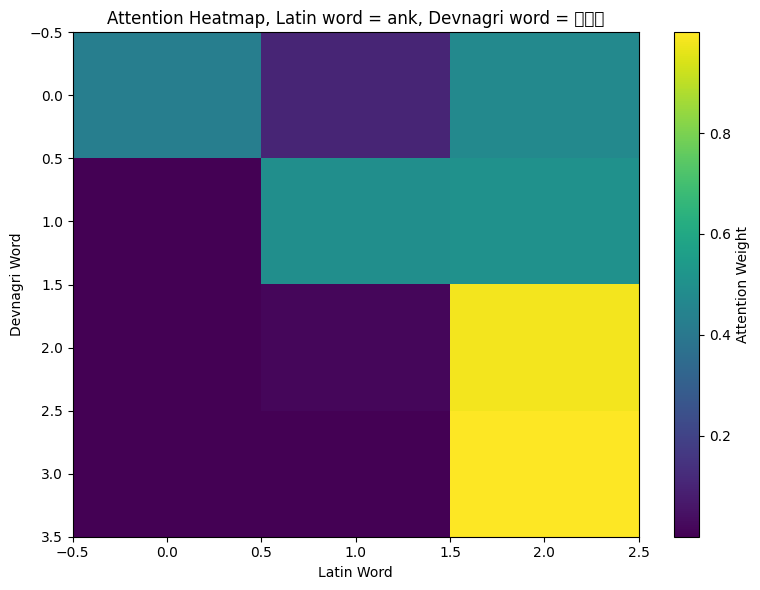

Latin word = ankit, Devnagri word = अंकित


/tmp/ipykernel_35/1991647216.py:30: UserWarning: Glyph 2367 (\N{DEVANAGARI VOWEL SIGN I}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/1991647216.py:30: UserWarning: Glyph 2340 (\N{DEVANAGARI LETTER TA}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2367 (\N{DEVANAGARI VOWEL SIGN I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2340 (\N{DEVANAGARI LETTER TA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


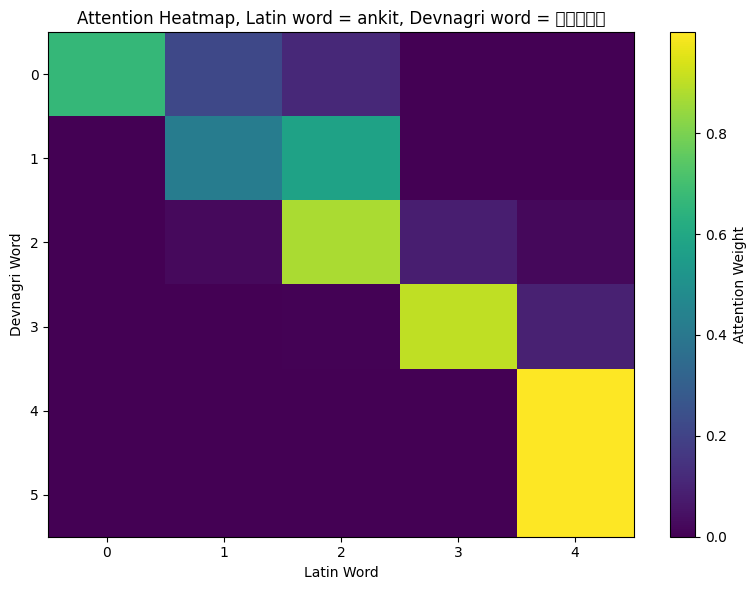

Latin word = ankon, Devnagri word = अंकों


/tmp/ipykernel_35/1991647216.py:30: UserWarning: Glyph 2379 (\N{DEVANAGARI VOWEL SIGN O}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2379 (\N{DEVANAGARI VOWEL SIGN O}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


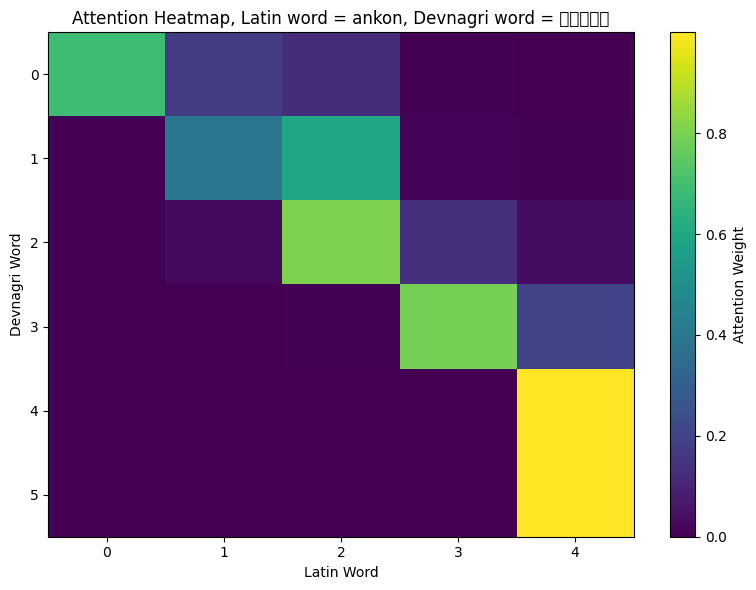

Latin word = ankor, Devnagri word = अंकोर


/tmp/ipykernel_35/1991647216.py:30: UserWarning: Glyph 2352 (\N{DEVANAGARI LETTER RA}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2352 (\N{DEVANAGARI LETTER RA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


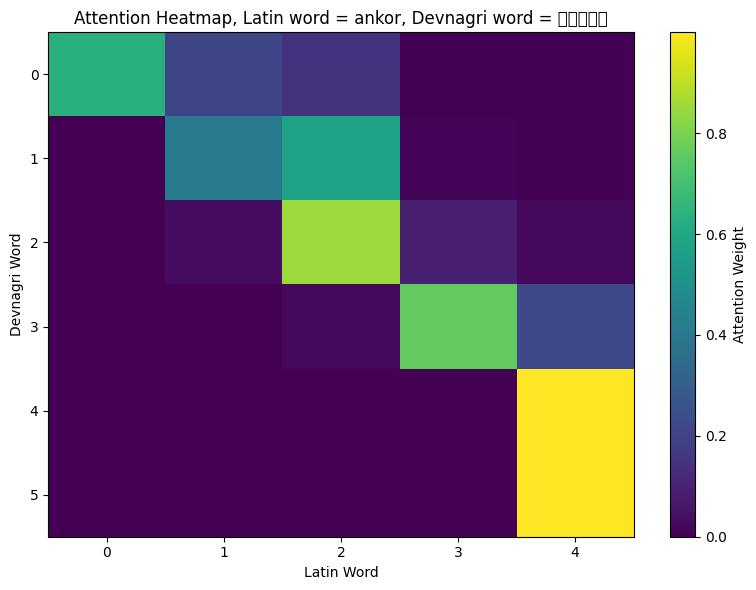

Latin word = angaarak, Devnagri word = अंगारक


/tmp/ipykernel_35/1991647216.py:30: UserWarning: Glyph 2327 (\N{DEVANAGARI LETTER GA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/1991647216.py:30: UserWarning: Glyph 2366 (\N{DEVANAGARI VOWEL SIGN AA}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2327 (\N{DEVANAGARI LETTER GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2366 (\N{DEVANAGARI VOWEL SIGN AA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


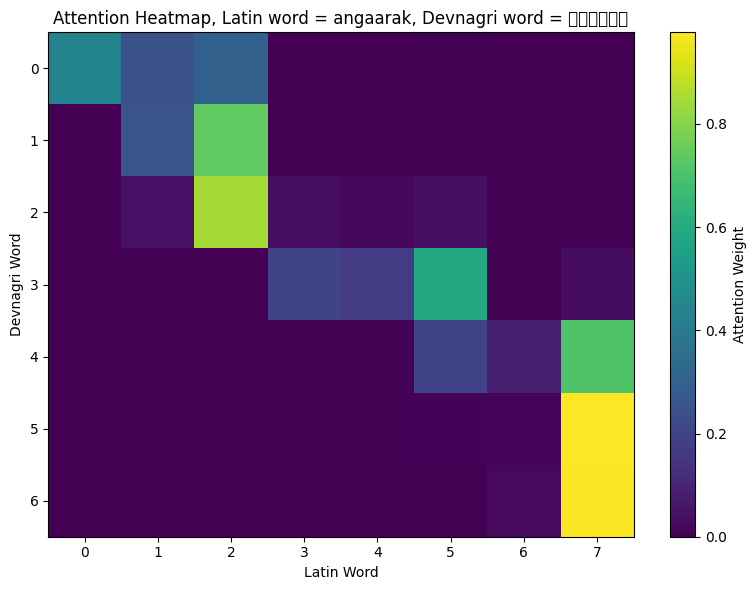

Latin word = angarak, Devnagri word = अंगारक


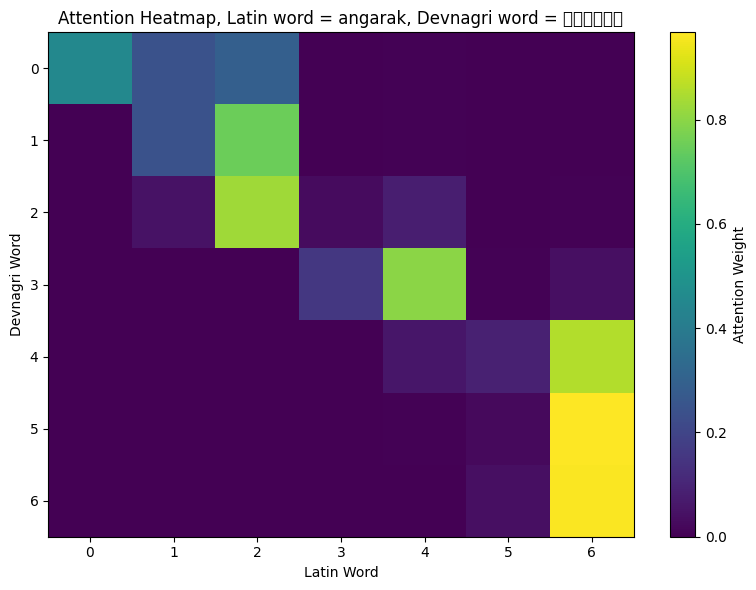

Latin word = andha, Devnagri word = अंधा


/tmp/ipykernel_35/1991647216.py:30: UserWarning: Glyph 2343 (\N{DEVANAGARI LETTER DHA}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2343 (\N{DEVANAGARI LETTER DHA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


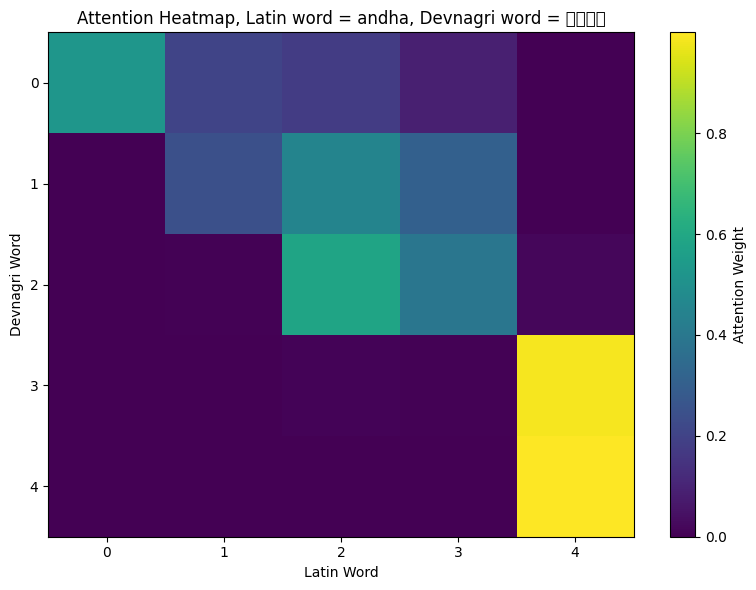

Latin word = andheri, Devnagri word = अंधेरी


/tmp/ipykernel_35/1991647216.py:30: UserWarning: Glyph 2375 (\N{DEVANAGARI VOWEL SIGN E}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/1991647216.py:30: UserWarning: Glyph 2368 (\N{DEVANAGARI VOWEL SIGN II}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2375 (\N{DEVANAGARI VOWEL SIGN E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2368 (\N{DEVANAGARI VOWEL SIGN II}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


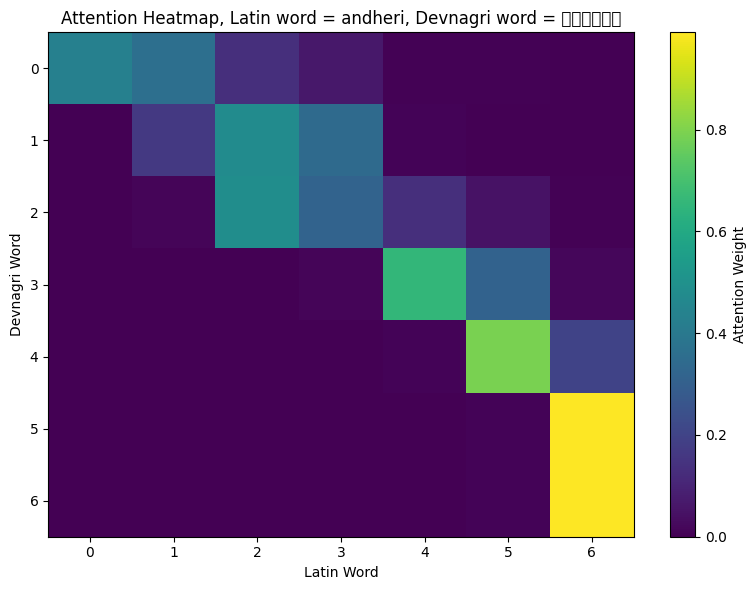

Latin word = ambaani, Devnagri word = अंबानी


/tmp/ipykernel_35/1991647216.py:30: UserWarning: Glyph 2348 (\N{DEVANAGARI LETTER BA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/1991647216.py:30: UserWarning: Glyph 2344 (\N{DEVANAGARI LETTER NA}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2348 (\N{DEVANAGARI LETTER BA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2344 (\N{DEVANAGARI LETTER NA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


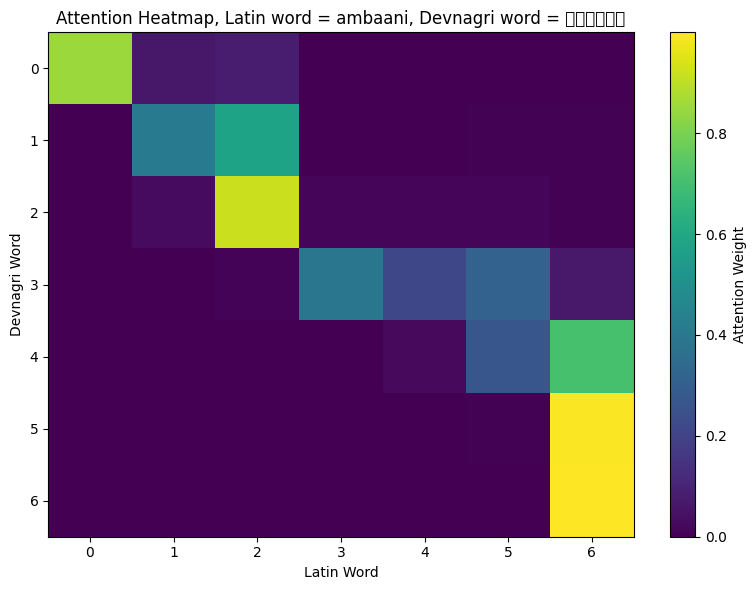

Latin word = ambani, Devnagri word = अंबानी


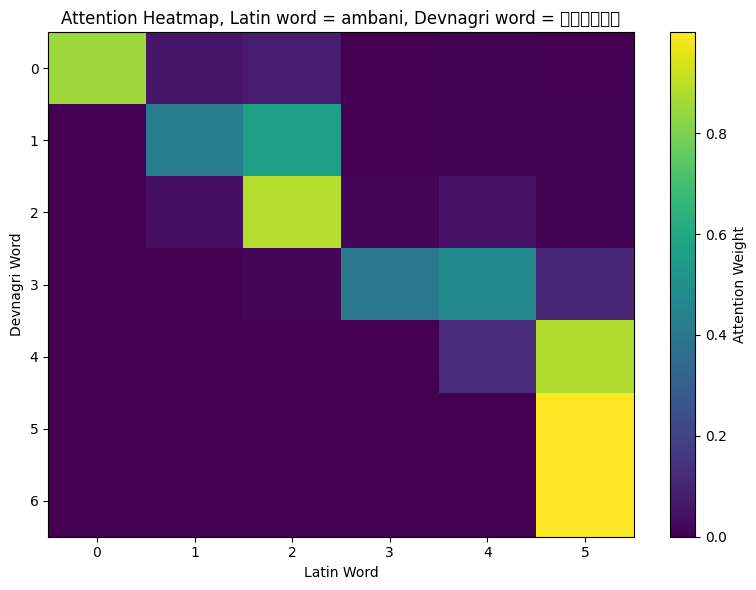

In [18]:
import matplotlib.pyplot as plt
import numpy as np
wordss_i=[]
for each in input_words: 
    wordss_i.append(get_words_from_tensor(each, input_char2idx, input_idx2char))
wordss_p=[]
for each in visual_words: 
    wordss_p.append(get_words_from_tensor(each, output_char2idx, output_idx2char))
i=0
for each in visual_att:
    attention_list = each  # ensure this is defined in your environment
    
    # Convert each weight tensor/array to a 1D numpy array
    attn_arrays = []
    for w in attention_list:
        arr = w.detach().cpu().numpy() if hasattr(w, 'detach') else np.array(w)
        arr = arr.squeeze()  # remove extra dims if present
        attn_arrays.append(arr)
    
    # Stack into a 2D array: shape (target_steps, source_length)
    attention_matrix = np.stack(attn_arrays, axis=0)
    print(f'Latin word = {wordss_i[i]}, Devnagri word = {wordss_p[i]}')
    # Plot heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(attention_matrix, aspect='auto')
    plt.xlabel('Latin Word')
    plt.ylabel('Devnagri Word')
    plt.title(f'Attention Heatmap, Latin word = {wordss_i[i]}, Devnagri word = {wordss_p[i]}')
    plt.colorbar(label='Attention Weight')
    plt.tight_layout()
    plt.show()

    i+=1

In [34]:
attention = visual_att[4]
target_tensor = visual_words[4]
a=input_words[4]

input_seq = a.tolist() if hasattr(a, 'tolist') else a
if isinstance(input_seq[0], list):
    input_seq = input_seq[0]

if input_seq[0] == input_char2idx['<sos>']:
    input_seq = input_seq[1:]
if input_char2idx.get('<eos>') in input_seq:
    input_seq = input_seq[:input_seq.index(input_char2idx['<eos>'])]
input_word = ''.join(input_idx2char[i] for i in input_seq)
print(input_word)
target_seq = target_tensor.tolist() if hasattr(target_tensor, 'tolist') else target_tensor
if isinstance(target_seq[0], list):
    target_seq = target_seq[0]
# Remove <sos> and truncate at <eos> if present
if target_seq[0] == output_char2idx['<sos>']:
    target_seq = target_seq[1:]
if output_char2idx.get('<eos>') in target_seq:
    target_seq = target_seq[:target_seq.index(output_char2idx['<eos>'])]

target_word = ''.join(output_idx2char[i] for i in target_seq)
print(len(target_word))
print(len(input_word))


angaarak
6
8


In [26]:
print(attention[0][0][0])

tensor(0.8505)


In [30]:

def sigmoid(x):
	z = 1/(1 + np.exp(-x))
	return z

def color(attn):
    colors = ['#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8'
		'#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
		'#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
		'#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e']
    value = sigmoid(attn)
    value = int((value * 100) / 5)
    return value

In [35]:
import wandb
import numpy as np
import json

hindi = list(target_word)
english = list(input_word)

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def color(attn):
    colors = [
      '#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8',
      '#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
      '#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
      '#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e2'
    ]
    v = sigmoid(attn)
    i = int((v * 100) // 5)  # 0–19
    return colors[i]

b=[]
for att in attention:
    a=[]
    for letter in att[0]:
        print(letter)
        a.append(letter)
    print("\n")
    b.append(a)
    
raw_attn=np.array(b)
color_matrix = [
    [color(a) for a in row]
    for row in raw_attn
]

# Build the HTML+JS, inlining color_matrix
html = f'''
<meta charset="utf-8">
<style>
  .eng-char {{
    transition: background-color 0.2s;
    padding: 2px; margin: 1px;
    display: inline-block;
  }}
  .hindi-char {{
    cursor: pointer; padding: 2px; margin: 1px;
    display: inline-block;
    border-bottom: 1px dashed #888;
  }}
</style>

<script>
// inline your precomputed hex colors
const colorData = {json.dumps(color_matrix)};

function onHover(idx) {{
  const row = colorData[idx];
  document.querySelectorAll('.eng-char').forEach((span, j) => {{
    span.style.backgroundColor = row[j];
  }});
}}

function onOut() {{
  document.querySelectorAll('.eng-char').forEach(span => {{
    span.style.backgroundColor = '';
  }});
}}
</script>

<div><strong>English input:</strong> {"".join(
    f'<span class="eng-char">{ch}</span>' for ch in english
)}</div><br/>

<div><strong>Hindi Prediction:</strong> {"".join(
    f'<span class="hindi-char" onmouseover="onHover({i})" '
    f'onmouseout="onOut()">{ch}</span>'
    for i,ch in enumerate(hindi)
)}</div>
'''

# log to W&B
wandb.login(key="70a00ae1607c730fb9cd50b1268b191bec7a2901")

wandb.init(project="attention-viz", name="Visualising Activations")
wandb.log({
    "char_attention": wandb.Html(html, inject=False)  # inject=False to keep our CSS/JS
})
wandb.finish()


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


tensor(0.4428)
tensor(0.2413)
tensor(0.3027)
tensor(0.0018)
tensor(0.0022)
tensor(0.0042)
tensor(0.0019)
tensor(0.0032)


tensor(1.1111e-05)
tensor(0.2529)
tensor(0.7374)
tensor(0.0012)
tensor(0.0022)
tensor(0.0026)
tensor(0.0014)
tensor(0.0022)


tensor(4.7622e-05)
tensor(0.0488)
tensor(0.8469)
tensor(0.0345)
tensor(0.0216)
tensor(0.0404)
tensor(0.0020)
tensor(0.0058)


tensor(4.0021e-05)
tensor(0.0004)
tensor(0.0027)
tensor(0.1976)
tensor(0.1696)
tensor(0.5936)
tensor(0.0045)
tensor(0.0316)


tensor(7.1458e-10)
tensor(4.7417e-09)
tensor(2.5665e-06)
tensor(0.0028)
tensor(0.0070)
tensor(0.1964)
tensor(0.0840)
tensor(0.7097)


tensor(5.4869e-11)
tensor(7.6782e-11)
tensor(1.2939e-08)
tensor(1.4809e-05)
tensor(0.0001)
tensor(0.0080)
tensor(0.0142)
tensor(0.9777)


tensor(7.3504e-16)
tensor(1.7165e-15)
tensor(3.7137e-11)
tensor(4.0969e-09)
tensor(1.9080e-07)
tensor(0.0018)
tensor(0.0258)
tensor(0.9724)




In [23]:
# import wandb
# import numpy as np

# # Example data

# hindi = target_word
# english = input_word
# # hindi = list("नमस्ते")               # your Hindi target chars
# # english = list("hello")             # your English input chars
# # attention[i, j] = attention weight from hindi[i] to english[j]
# b=[]
# attention = np.random.rand(len(hindi), len(english))
# for att in attention:
#     a=[]
#     for letter in att:
#         print(letter)
#         a.append(color(letter))
#     print("\n")
#     b.append(a)
# attention=b
# # Normalize along the English axis for nicer weight scaling
# # attention = attention / attention.max(axis=1, keepdims=True)

# # Build HTML
# html_parts = []

# # Inline CSS for styling
# html_parts.append("""
# <meta charset="utf-8">
# <style>
#   .eng-char { 
#     transition: background-color 0.2s; 
#     padding: 2px; 
#     margin: 1px;
#     display: inline-block;
#   }
#   .hindi-char { 
#     cursor: pointer; 
#     padding: 2px; 
#     margin: 1px; 
#     display: inline-block;
#     border-bottom: 1px dashed #888;
#   }
# </style>
# <script>
#   function onHover(idx) {
#     const weights = attentionData[idx];
#     // find all english spans
#     document.querySelectorAll('.eng-char').forEach((span, j) => {
#       const w = weights[j];
#       // map weight [0,1] to a light-yellow -> orange
#       const intensity = Math.floor(255 - w * 120);
#       span.style.backgroundColor = `rgb(255, ${intensity}, 0)`;
#     });
#   }
#   function onOut() {
#     document.querySelectorAll('.eng-char').forEach(span => {
#       span.style.backgroundColor = '';
#     });
#   }
# </script>
# """)

# # Attach the attention matrix itself into JS
# # (You could also fetch it via AJAX; here we inline for simplicity.)
# html_parts.append(f"<script>const attentionData = {attention};</script>")

# # Render the English chars
# html_parts.append("<div><strong>English input:</strong> ")
# for j, ch in enumerate(english):
#     html_parts.append(f'<span class="eng-char" id="e{j}">{ch}</span>')
# html_parts.append("</div><br/>")

# # Render the Hindi chars with mouse handlers
# html_parts.append("<div><strong>Hindi (hover):</strong> ")
# for i, ch in enumerate(hindi):
#     html_parts.append(
#         f'<span class="hindi-char" '
#         f'onmouseover="onHover({i})" onmouseout="onOut()">{ch}</span>'
#     )
# html_parts.append("</div>")

# html = "\n".join(html_parts)

# # Initialize W&B and log
# wandb.login(key="cfd69ff349d7e9fbbc2b83cd0c851869cc64800a")

# wandb.init(project="attention-viz", name="Visualising Activations")
# wandb.log({
#     "char_attention": wandb.Html(html, inject=False)  # inject=False to keep our CSS/JS
# })
# wandb.finish()

